## Eliminating features
There are 507 features- that's too many and probably contains alot of useless features which will cause overfitting. It also takes longer to process anything, so I use SelectKBest to cut down to 400, remove correlated features (down to 291), and Recursive Feature Elimination to reduce them to 43 features. 

In [1]:
#Import the relevant dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score 

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:
df=pd.read_csv(r'/Users/ftt.huien.pang/Documents/Grab_AISEA/safety/features/dataframeD.csv')

### SelectKBest
Referenced from <a href="https://machinelearningmastery.com/feature-selection-machine-learning-python/ ">feature selection techniques</a>, I used this to select that have the strongest relationship with the output variable based on the top 400 highest scores.

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = df.drop(columns=['Unnamed: 0','bookingID','label']).reset_index(drop=True)
y = df['label']
selector=SelectKBest(score_func=f_classif,k=400)
selector.fit(X,y)

#set_printoptions(precision=3)
#print(fit.scores_)
features=selector.transform(X)
print(features.shape)

cols=X.columns[selector.get_support(indices=True)].tolist()
print(cols)

(19982, 400)
['Accuracy_max', 'Accuracy_skew', 'Accuracy_range', 'Accuracy_maxtoMin', 'Accuracy_abs_max', 'Accuracy_abs_avg', 'Accuracy_ssc', 'Accuracy_skewness', 'Accuracy_wave_length', 'Accuracy_kurtosis', 'Bearing_mean', 'Bearing_median', 'Bearing_max', 'Bearing_min', 'Bearing_std', 'Bearing_skew', 'Bearing_range', 'Bearing_mean_abs_chg', 'Bearing_abs_max', 'Bearing_abs_min', 'Bearing_abs_avg', 'Bearing_mad', 'Bearing_q25', 'Bearing_q75', 'Bearing_iqr', 'Bearing_ssc', 'Bearing_mean_abs', 'Bearing_skewness', 'Bearing_wave_length', 'Bearing_norm_entropy', 'Bearing_SRAV', 'Bearing_kurtosis', 'Bearing_sign_change', 'Bearing_percentile_90', 'acceleration_x_max', 'acceleration_x_min', 'acceleration_x_std', 'acceleration_x_skew', 'acceleration_x_range', 'acceleration_x_mean_abs_chg', 'acceleration_x_abs_max', 'acceleration_x_abs_avg', 'acceleration_x_mad', 'acceleration_x_q25', 'acceleration_x_q75', 'acceleration_x_iqr', 'acceleration_x_ssc', 'acceleration_x_mean_abs', 'acceleration_x_skew

/Users/ftt.huien.pang/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [481] are constant.
  UserWarning)
/Users/ftt.huien.pang/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [4]:
df.head()

,Unnamed: 0,bookingID,Accuracy_mean,Accuracy_median,Accuracy_max,Accuracy_min,Accuracy_std,Accuracy_skew,Accuracy_range,Accuracy_maxtoMin,...,gyro_tot_diff_sign_change,freq_accdiff_above5,freq_accdiff_below5,freq_speeddiff_above5,freq_speeddiff_below5,freq_gyrodiff,freq_bearingdiff,second_max,Distance_sum,label
0,0,0,10.165339,8.000,48.000,4.0,3.855898,1.735289,44.000,12.000000,...,516,0.000000,0.000000,0.001992,0.000996,15,7,1589.0,1.109044e+07,0
1,1,1,3.718763,3.900,7.709,3.0,0.597933,1.261464,4.709,2.569667,...,425,0.000000,0.000000,0.007051,0.007051,3,15,1034.0,4.699164e+06,1
2,2,2,3.930626,3.634,8.000,3.0,1.117354,1.335529,5.000,2.666667,...,101,0.000000,0.000000,0.000000,0.000000,1,5,825.0,1.664297e+05,1
3,3,4,10.000000,10.000,10.000,10.0,0.000000,0.000000,0.000,1.000000,...,564,0.002742,0.001828,0.000000,0.000000,13,6,1094.0,4.316770e+06,1
4,4,6,4.586721,4.004,12.000,3.0,1.329545,1.699839,9.000,4.000000,...,550,0.000000,0.000000,0.000000,0.000000,12,6,1094.0,3.458177e+06,0


### Remove correlated features
Referenced from 
<a href="https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15">this link </a>, which suggested to remove correlated features because they provide the same information; and because RFE takes a long time to run. I removed features with correlation > 0.8. 

In [5]:
dfE=df.copy()
dfE=dfE[cols]

In [6]:
correlated_features=set()
correlation_matrix=dfE.corr()

In [7]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j])>0.8:
            colname=correlation_matrix.columns[i]
            correlated_features.add(colname)

In [8]:
new_cols=correlated_features

### Recursive Feature Elimination
Now that we are down to 291 features, we can use Recursive Feature Elimination to potentially get to the top 50. This was referenced from <a href="https://machinelearningmastery.com/feature-selection-machine-learning-python/ ">this link <a>.

In [9]:
X =  df.drop(columns=['Unnamed: 0','bookingID','label']).reset_index(drop=True)[new_cols]
y = df['label']
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=123)

In [10]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

/Users/ftt.huien.pang/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
from sklearn.feature_selection import RFECV

rfc=lgb.LGBMClassifier(random_state=55)
rfecv=RFECV(estimator=rfc, cv=StratifiedKFold(5),scoring='roc_auc')
rfecv.fit(X_train,y_train)

In [12]:
print('Optimal number of features:{}'.format(rfecv.n_features_))

Optimal number of features:43


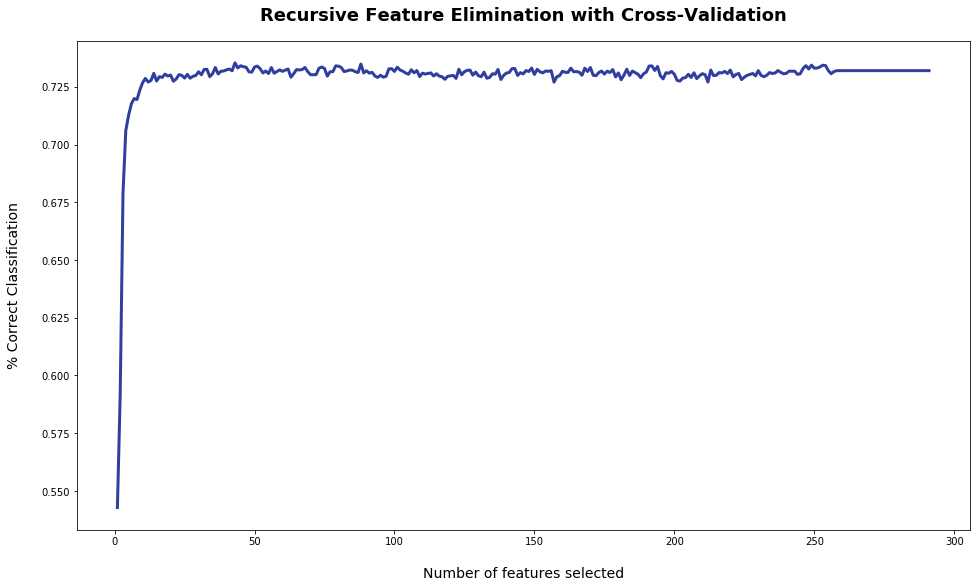

In [13]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [14]:
rfecv.estimator_.feature_importances_

array([ 55,  63,  72,  62,  57,  76,  49,  65,  61,  62,  74,  59,  68,
        71,  64,  58,  63,  83, 174,  62,  63,  83,  58,  91,  60,  81,
        73,  62,  57,  73,  62,  68,  82,  68,  82,  64,  73,  52,  92,
        60,  53,  85,  60], dtype=int32)

In [15]:
print(np.where(rfecv.support_==False)[0])
X_train.drop(X_train.columns[np.where(rfecv.support_==False)[0]],axis=1, inplace=True)

[  0   2   3   4   5   6   7   9  10  11  12  13  14  15  17  18  21  23
  24  25  27  28  29  30  31  33  34  36  37  38  39  40  41  42  43  46
  47  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  70  71  72  73  75  76  77  78  80  81  82  83  85  87  88
  89  90  91  92  93  94  95  96  97  98  99 101 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 120 121 122 123 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 151 152 153 154 155 156 157 159 160 161 162 163 164 165 167
 169 170 171 173 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 198 199 201 202 203 204 205 206 207 210 211
 212 213 214 215 217 218 219 221 222 223 224 225 226 227 228 229 230 231
 233 234 235 236 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 254 255 256 257 258 259 260 261 262 263 266 267 268 271 272 273 274
 275 276 277 278 280 282 283 284 285 286 287 288 28

/Users/ftt.huien.pang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
feat_cols=X_train.columns

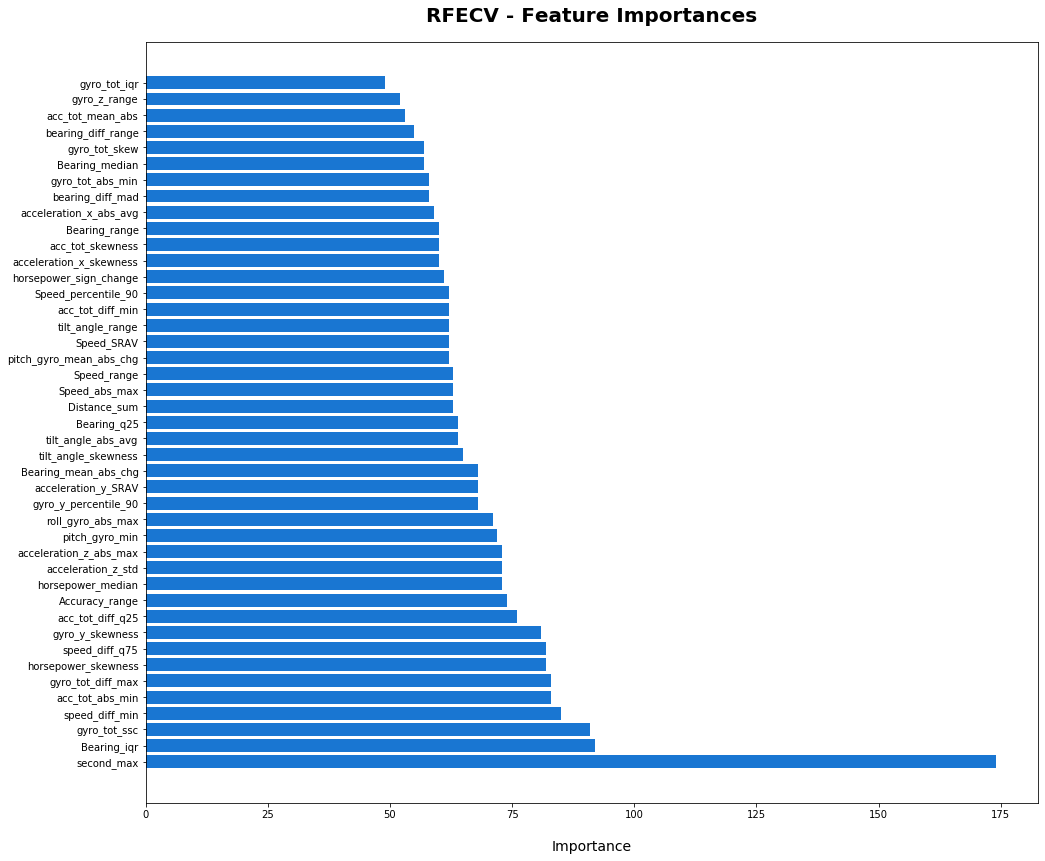

In [17]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

These are our top features after RFE!!

## Model selection
The codes to generate the neat plots showing the top features were referenced from <a href="https://github.com/erichooi/Grab-AI-For-S.E.A./blob/master/AI%20for%20S.E.A.%20(Safety%20Track).ipynb">erichooi's notebook </a>.     
We ran those models based on their default parameters and LightGBM and Decision tree performed the best (ROC_AUC: 0.58++). 

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from operator import itemgetter

In [28]:
df=pd.read_csv(r'/Users/ftt.huien.pang/Documents/Grab_AISEA/safety/features/dataframeD.csv')

In [23]:
len(feat_cols)

43

In [29]:
X =  df.drop(columns=['Unnamed: 0','bookingID','label']).reset_index(drop=True)[feat_cols]
y = df['label']
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=123)

In [30]:
tree_based_models = {
    "dt": DecisionTreeClassifier(),
    "rf": RandomForestClassifier(),
    "ada": AdaBoostClassifier(),
    "gb": GradientBoostingClassifier(),
    "xgb": XGBClassifier(),
    "lgb": LGBMClassifier(),
    "sgd": SGDClassifier()
}

In [31]:
for _, clf in tree_based_models.items():
    
    print("Model name:"+ _,)
    skf=StratifiedKFold(n_splits=5, random_state=99, shuffle = True) #the cross_val_score dropped by 10 when I put shuffle=True
    model=clf
    model.fit(X_train, y_train) 
    res = cross_val_score(model,X_train,y_train,cv=skf,scoring='roc_auc')
    print(f"StratifiedCV _ Scores : {res}")
    print(f"mean StratifiedCV _ Scores : {res.mean()}")
    
    test = y_test.T
    df = pd.Series(test)
    grouped = df.groupby(df).count()
    print("Number of occurence of each value in result test set :")
    print(grouped)

    yhat=model.predict(X_test)
    test2 = yhat.T
    df = pd.Series(test2)
    grouped = df.groupby(df).count()
    print("Number of occurence of each value in result test set after going through the ML:")
    print(grouped)

    print ("Classification report : \n" + classification_report(y_test, yhat))
    scores=roc_auc_score(y_test, yhat)
    print("ROC_AUC_score :")
    print(scores)

Model name:dt
StratifiedCV _ Scores : [0.58798342 0.57402326 0.59277717 0.58319123 0.59049046]
mean StratifiedCV _ Scores : 0.5856931059657906
Number of occurence of each value in result test set :
label
0    3014
1     983
Name: label, dtype: int64
Number of occurence of each value in result test set after going through the ML:
0    3018
1     979
dtype: int64
Classification report : 
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      3014
           1       0.37      0.37      0.37       983

    accuracy                           0.69      3997
   macro avg       0.58      0.58      0.58      3997
weighted avg       0.69      0.69      0.69      3997

ROC_AUC_score :
0.5824490796088245
Model name:rf


/Users/ftt.huien.pang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


StratifiedCV _ Scores : [0.6898399  0.66619107 0.68604636 0.67232974 0.68830648]
mean StratifiedCV _ Scores : 0.6805427096370463
Number of occurence of each value in result test set :
label
0    3014
1     983
Name: label, dtype: int64
Number of occurence of each value in result test set after going through the ML:
0    3656
1     341
dtype: int64
Classification report : 
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      3014
           1       0.54      0.19      0.28       983

    accuracy                           0.76      3997
   macro avg       0.66      0.57      0.57      3997
weighted avg       0.72      0.76      0.71      3997

ROC_AUC_score :
0.5682204645530083
Model name:ada
StratifiedCV _ Scores : [0.73672168 0.72006466 0.74649718 0.71577128 0.72161478]
mean StratifiedCV _ Scores : 0.728133917396746
Number of occurence of each value in result test set :
label
0    3014
1     983
Name: label, dtype: int64
Number of occ

## Visualising the top features

In [32]:
for _, clf in tree_based_models.items():
    clf.fit(X, y)

In [33]:
def generate_sorted_feature_importance(columns_name, feature_importances):
    feature_importance_map = {}
    for i in range(len(columns_name)):
        feature_importance_map[columns_name[i]] = feature_importances[i]
    sorted_feature_importance = dict(sorted(feature_importance_map.items(), key=itemgetter(1)))
    return sorted_feature_importance

def plot_feature_importance(sorted_feature_importance, ax, title):
    num_feature = 20
    bp = sns.barplot(list(sorted_feature_importance.keys())[-num_feature:], list(sorted_feature_importance.values())[-num_feature:], ax=ax)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
    bp.set_title(title)
    return bp

AttributeError: 'SGDClassifier' object has no attribute 'feature_importances_'

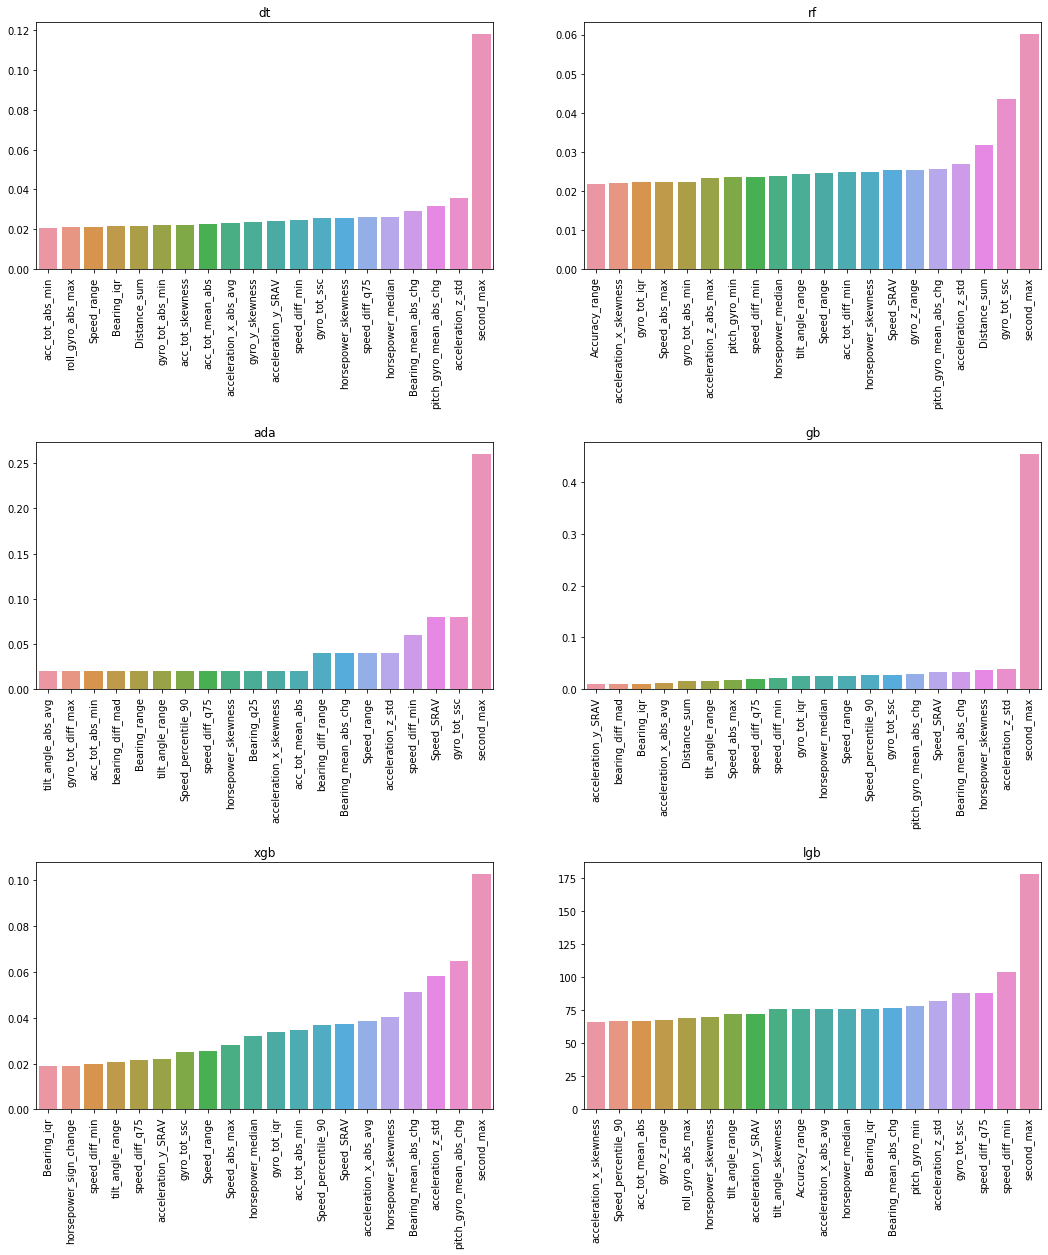

In [34]:
# to visualize the 20 most important features of each tree-based models
fig, axes = plt.subplots(3, 2)
fig.set_figheight(20)
fig.set_figwidth(18)
fig.subplots_adjust(hspace=0.7)
count = 0
for name, clf in tree_based_models.items():
    row = count // 2
    column = count % 2
    sorted_feature_importance = generate_sorted_feature_importance(X.columns, clf.feature_importances_)
    plot_feature_importance(sorted_feature_importance, axes[row, column], name)
    count += 1

From plot:
- 'second_max' is consistently the number 1 feature for all models. However, the subsequent top features differ alot between the models.
- 'gyro_tot_ssc' and 'acceleration_z_std' is the second top for some of the models.

## Looking at the top features

In [55]:
df=pd.read_csv(r'/Users/ftt.huien.pang/Documents/Grab_AISEA/safety/features/dataframeD.csv')

In [52]:
def plot_distribution(data_select) : 
    figsize =( 30, 25)
    sns.set_style("ticks")
    s = sns.FacetGrid(df, hue = 'label',aspect = 2.5, palette ={0 : 'blue', 1 :'red'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(df[data_select].min(), df[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'feature proportion')
    s.fig.suptitle(data_select)
    plt.show()

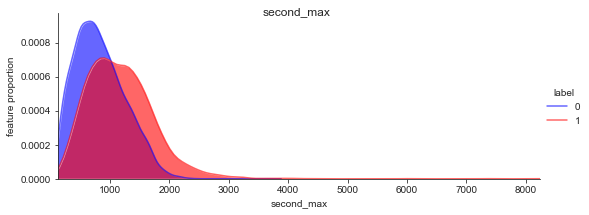

In [56]:
plot_distribution('second_max')

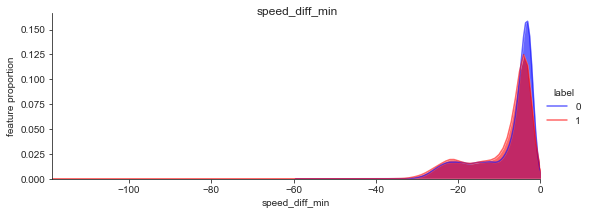

In [57]:
plot_distribution('speed_diff_min')

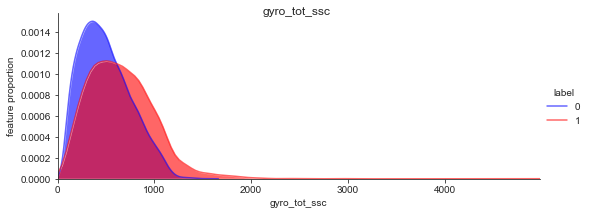

In [59]:
plot_distribution('gyro_tot_ssc') 

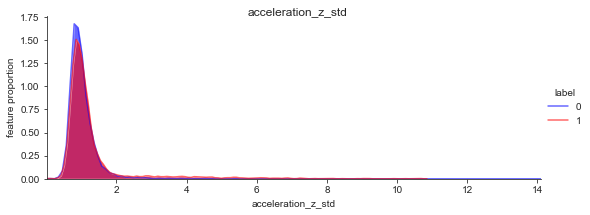

In [60]:
plot_distribution('acceleration_z_std')

From plots:
- 'second_max' and 'gyro_tot_ssc' has a weirdly similar distribution. I'm not sure how to make sense of it...
- 'second max'i.e. the length of the trip could disttinguish between safe and unsafe drivers; and unsafe drivers tend to have longer trips than safe drivers. 
- 1- labelled drivers (unsafe) has a longer tail end for 'speed_diff_min'; showing that they tend to have bigger decreases in speed/ magnitude of braking than safe drivers.